In [3]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score

import opensoundscape
from opensoundscape import Audio, Spectrogram

import bioacoustics_model_zoo as bmz
from opensoundscape.ml.shallow_classifier import (
    MLPClassifier,
    quick_fit,
    fit_classifier_on_embeddings
)

from scipy.special import softmax
from matplotlib import pyplot as plt
from collections import defaultdict



ModuleNotFoundError: No module named 'opensoundscape'

In [4]:
datapath = "/workspaces/non-avian-ml-toy/data/audio"
species_list = ["bullfrog", "coyote", 'noise']

datatype = "data"

# audio
# - bullfrog
#   - data
#       - pos
#       - neg
# - coyote
#   - data
#      - pos 
# '/workspaces/non-avian-ml-toy/data/audio/bullfrog/data/neg/bullfrog-neg-t-11113588_9.wav' # Following this format
# Creating a dataframe for each animal species with file paths and labels

df_each_species = defaultdict(list) # Create a dictionary to hold dataframes for each species
# df_each_species = animal_species: df
# Combine all species dataframes into one

# Note Can also use OneHotEncoder in Sckit-learn
all_species = pd.DataFrame()
for species in species_list:
    # Files Paths
    pos_files = glob.glob(os.path.join(datapath, species, datatype, "pos", "*.wav")) # List of Each species pos files
    neg_files = glob.glob(os.path.join(datapath, species, datatype, "neg", "*.wav")) # List of Each species pos files
    all_files = pos_files + neg_files # Combine all file paths

    # Encoding
    pos_files_init = [1] * len(pos_files) # List of 1s for each positive file
    neg_files_init = [0] * len(neg_files) # List of 0s for each negative file
    encoding_pos_files = pos_files_init + neg_files_init
    encoding_neg_files = neg_files_init + pos_files_init

    pd_each_species = pd.DataFrame({'files': all_files, species: encoding_pos_files, 'noise': encoding_neg_files})
    df_each_species[species] = pd_each_species

for species in species_list:
    all_species = pd.concat([all_species, df_each_species[species]], axis=0)

# Fill NaN values with 0, set index, convert to int
all_species.fillna(0, inplace=True)  # Replace NaN values with 0
all_species.set_index("files", inplace=True)  # Set 'files' as the index
all_species = all_species.astype(int)  # Convert to int

# Optionally putting other in the last Row
if True:
    other_col = all_species.pop("noise")
    all_species.insert(len(all_species.columns), "noise", other_col)
idx_to_all_species = {i: col for i, col in enumerate(all_species.columns)}

df_each_species
all_species



NameError: name 'defaultdict' is not defined

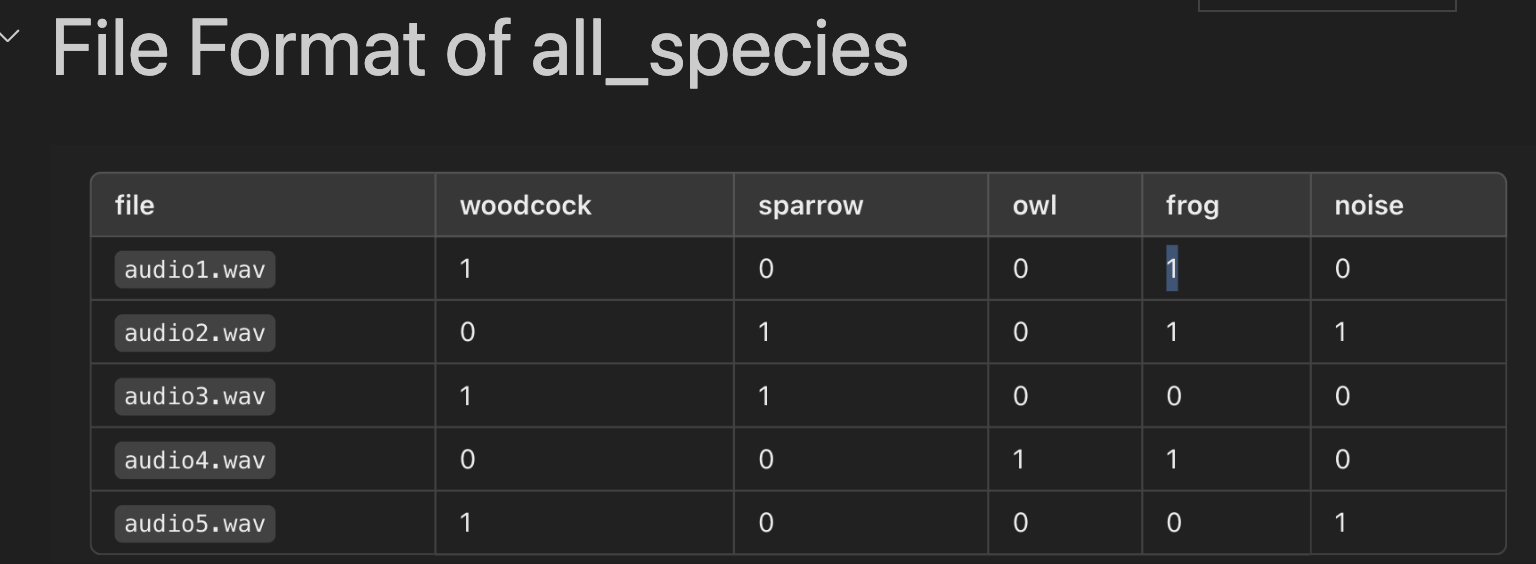


In [4]:
model = bmz.BirdNET()

CPU CORES: 9


NameError: name 'bmz' is not defined

In [21]:
# Use maximum CPUs for your device
num_workers = os.cpu_count() * 3 // 4  

curr_df = df_each_species['coyote']

file_paths = curr_df['files'] 
labels = curr_df['coyote']  

fold_num = 5
skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=8)

ROC_AUC_scores = []

# Perform Stratified K-Fold
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(file_paths, labels)):  
    train_files, test_files = file_paths.iloc[train_idx].tolist(), file_paths.iloc[test_idx].tolist()
    labels_train, labels_val = labels.iloc[train_idx], labels.iloc[test_idx]
    print(train_files, test_files)

    # Reshape labels to match the model output shape
    labels_train = labels_train.to_numpy().reshape(-1, 1)  
    labels_val = labels_val.to_numpy().reshape(-1, 1)  

    # Generate embeddings for training and validation sets
    emb_train = model.embed(train_files, return_dfs=False, batch_size=4, num_workers=num_workers)
    emb_val = model.embed(test_files, return_dfs=False, batch_size=4, num_workers=num_workers)

    # Define class for training (only "bullfrog")
    classes = ['bullfrog']
    model.change_classes(classes)

    # Fit the classification head with embeddings and labels
    model.network.fit(emb_train, labels_train, emb_val, labels_val)

    # Make predictions by passing the embeddings through the classifier
    # https://github.com/kitzeslab/bioacoustics-model-zoo/blob/main/bioacoustics_model_zoo/tensorflow_wrapper.py#L19


    # NEED TO CHANGE THIS I don't think this is correct
    preds = model.network(torch.tensor(emb_val)).detach() # Return raws logits of predictions not the preds
    
    curr_score = roc_auc_score(labels_val, preds, average=None) 
    ROC_AUC_scores.append(curr_score)

    # Plot histogram of predictions
    preds = preds.detach().numpy()
    # plt.hist(preds[labels_val == 1], bins=20, alpha=0.5, label='Bullfrog Present')
    # plt.hist(preds[labels_val == 0], bins=20, alpha=0.5, label='Bullfrog Absent')
    # plt.title(f"Fold {fold_idx + 1}")
    # plt.legend()
    # plt.show()

    # Print Fold Information
    # print('---------------------------')
    # print(f"Current Fold: {fold_idx + 1}")
    # print(f"ROC AUC Score: {curr_score}\n")


CPU CORES: 9


NameError: name 'bmz' is not defined

In [ ]:
# Average ROC AUC score across all folds
average_roc_auc = np.mean(ROC_AUC_scores)
for i, score in enumerate(ROC_AUC_scores):
    print(f"Fold {i + 1}: ROC AUC Score = {score}")
print(f'Average Across All folds: {average_roc_auc}')